In [ ]:
!pip install livelossplot

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from matplotlib import pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from livelossplot import PlotLossesKeras

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
DICT_SIZE = 2048 #1500 4096
REVIEW_LEN = 256 #150

In [ ]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=DICT_SIZE)

17464789/17464789 [==============================] - 0s 0us/step


In [ ]:
X_train = tf.keras.utils.pad_sequences(X_train, maxlen=REVIEW_LEN)
X_test = tf.keras.utils.pad_sequences(X_test, maxlen=REVIEW_LEN)

In [ ]:
word_index = tf.keras.datasets.imdb.get_word_index()

1641221/1641221 [==============================] - 0s 0us/step


In [ ]:
def decode_review(X, index=24):
  reverse_index = dict([(value,key) for (key,value) in word_index.items()])
  decoded_review = " ".join([reverse_index.get(i-3, "-X-") for i in X[index]])
  print(decoded_review)
  return decoded_review

In [ ]:
decode_review(X_train, 9)

-X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- this movie has many problem -X- with it that makes it come off like a low budget class project from someone in film school i have to give it credit on its -X- though many times throughout the movie i found myself laughing -X- it was so bad at times that it was -X- which made it a fun watch br br if you're looking for a low grade slasher movie with a twist of psychological horror and a -X- of -X- -X- then pop a -X- of -X- -X- some friends over and have some fun br br i agree with other co

"-X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- -X- this movie has many problem -X- with it that makes it come off like a low budget class project from someone in film school i have to give it credit on its -X- though many times throughout the movie i found myself laughing -X- it was so bad at times that it was -X- which made it a fun watch br br if you're looking for a low grade slasher movie with a twist of psychological horror and a -X- of -X- -X- then pop a -X- of -X- -X- some friends over and have some fun br br i agree with other c

In [ ]:
extract_regularizer = lambda layer: str(type(layer.kernel_regularizer)).split(".")[-1][:-2]
def get_regularizer_and_value(layer):
  regularizer_name = extract_regularizer(layer) if hasattr(layer, "kernel_regularizer") and extract_regularizer(layer) in ["L1", "L2"] else None
  if regularizer_name:
    isL1 = regularizer_name == "L1"
    value = layer.kernel_regularizer.l1 if isL1 else layer.kernel_regularizer.l2
    regularizer_name = regularizer_name + "=" + str(value)
  return regularizer_name

def get_padding(layer):
  value = "--"
  if type(layer) == tf.keras.layers.Conv2D:
    value = layer.padding
  return value
def table_summary_model(model):
  table=pd.DataFrame(columns=["Name","Type","Shape", "# Params", "Activation", "Regularizer", "Padding"])
  for layer in model.layers:
    activation_fn_name = layer.activation.__name__ if hasattr(layer, "activation") else None
    regularizer_name = get_regularizer_and_value(layer)
    padding = get_padding(layer)
    table = table.append({"Name":layer.name, "Type": layer.__class__.__name__,"Shape":layer.output_shape, "Activation": activation_fn_name, "# Params": layer.count_params(), "Regularizer": regularizer_name, "Padding": padding}, ignore_index=True)
  return table

def latex_table_summary(model):
  table = table_summary_model(model)
  print(table.to_latex(index=False))
  return

In [ ]:
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input, Bidirectional
from tensorflow.keras.models import Model

In [ ]:
def create_simple():
  input = Input(shape=(None,))
  x = Embedding(DICT_SIZE, 32, input_length=len(X_train[0]))(input)
  x = LSTM(16)(x)
  output = Dense(1, activation="sigmoid")(x)

  model = Model(input, output)
  model.compile(
      optimizer="adam",
      metrics=["acc"],
      loss="binary_crossentropy"
  )
  return model

In [ ]:
def create_baseline_model():
  input = Input(shape=(None,))
  x = Embedding(DICT_SIZE, 32, input_length=len(X_train[0]))(input)
  x = LSTM(64)(x)
  output = Dense(1, activation="sigmoid")(x)

  model = Model(input, output)
  model.compile(
      optimizer="adam",
      metrics=["acc"],
      loss="binary_crossentropy"
  )
  return model

In [ ]:
from tensorflow.keras.layers import Attention

def create_model_with_attention():
    input = Input(shape=(None,))
    x = Embedding(DICT_SIZE, 64, input_length=len(X_train[0]))(input)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Conv1D(8, 5, activation="relu", padding="same")(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = Bidirectional(LSTM(64,
                           dropout=.1,
                           recurrent_dropout=.1,
                           return_sequences=True))(x)

    attention = Attention()([x, x])
    x = tf.keras.layers.concatenate([x, attention])

    x = Bidirectional(LSTM(32))(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = Dense(32, activation="relu", kernel_regularizer=tf.keras.regularizers.L2())(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    output = Dense(1, activation="sigmoid")(x)

    model = Model(input, output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        metrics=["acc"],
        loss="binary_crossentropy"
    )

    return model

In [ ]:
def create_train_model(m_fn, X, y, X_val, y_val, epochs, batch_size, callbacks=[], v=False):
  m = m_fn()
  m_h = m.fit(
      X,
      y,
      validation_data = (X_val, y_val),
      epochs=epochs,
      batch_size=batch_size,
      callbacks=callbacks,
      verbose=v
  )
  return m, m_h

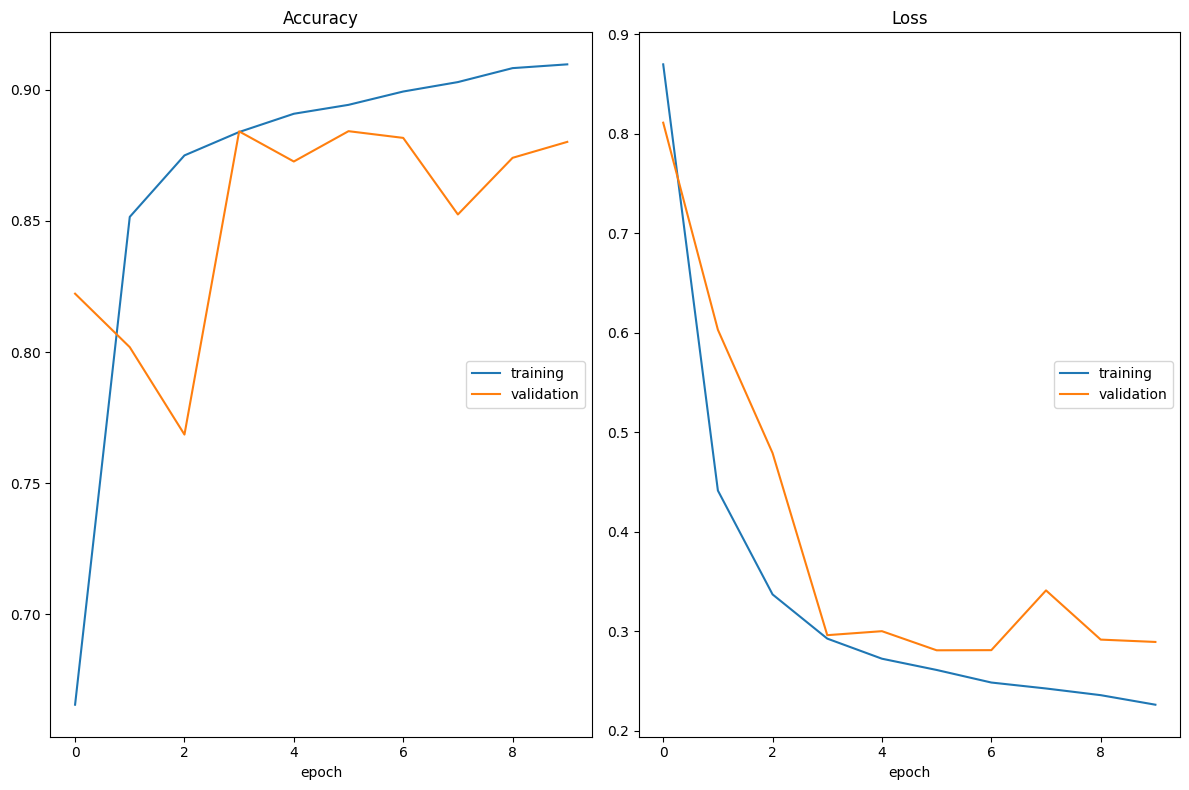

Accuracy
	training         	 (min:    0.666, max:    0.910, cur:    0.910)
	validation       	 (min:    0.769, max:    0.884, cur:    0.880)
Loss
	training         	 (min:    0.226, max:    0.870, cur:    0.226)
	validation       	 (min:    0.281, max:    0.811, cur:    0.289)
196/196 [==============================] - 345s 2s/step - loss: 0.2261 - acc: 0.9097 - val_loss: 0.2892 - val_acc: 0.8802


(<keras.src.engine.functional.Functional at 0x7b2dd67f6830>,
 <keras.src.callbacks.History at 0x7b2d5a72b9d0>)

In [ ]:
BASELINE_BATCH_SIZE = 128
BASELINE_EPOCHS = 10
BASELINE_CALLBACKS = [
    PlotLossesKeras(),
    #tf.keras.callbacks.LearningRateScheduler(
    #    lambda epoch: 0.001 if epoch < 6 else 0.0005
    #)
]

m, m_h = create_train_model(create_model_with_attention,
                   X_train,
                   y_train,
                   X_test,
                   y_test,
                   epochs=BASELINE_EPOCHS,
                   batch_size=BASELINE_BATCH_SIZE,
                   callbacks=BASELINE_CALLBACKS,
                   v=True
)


In [ ]:
from sklearn.model_selection import KFold

epochs = 5
batch_size = 128
callbacks = [
    #tf.keras.callbacks.LearningRateScheduler(
    #    lambda epoch: 0.001 if epoch < 6 else 0.0005
    #)
]


k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

accuracy_scores = []
hs = []
fn = 0
for train_index, val_index in kf.split(X_train, y_train):
    fn += 1
    X_train_fold, X_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]
    m, h_m = create_train_model(
        create_model_with_attention,
        X_train_fold,
        y_train_fold,
        X_val_fold,
        y_val_fold,
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        v=False
    )
    accuracy = accuracy_score(y_val_fold, m.predict(X_val_fold))
    print("Fold ", fn, " acc: ", accuracy)
    accuracy_scores.append(accuracy)
    hs.append(h_m)

In [ ]:
def collect_data(hs):
  output_data = dict()
  recorded_data_types = list(hs[0].history.keys())
  data_df = pd.DataFrame([h.history for h in hs])
  output_data = dict()
  for data_type in recorded_data_types:
    fold_info_array = []
    for fold_info in data_df[data_type]:
      fold_info_array.append(fold_info)
    output_data[data_type] = np.array(fold_info_array).mean(axis=0)
  return output_data

def plot_acc_ls(avg_loss_t, avg_acc_t, avg_loss_v, avg_acc_v, lr):
  plt.figure(figsize=(6, 10))

  # Loss Plot
  plt.subplot(1, 2, 1)
  plt.plot(avg_loss_t, label='Average Training Loss')
  plt.plot(avg_loss_v, label='Average Validation Loss')
  plt.title('Average Loss Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Accuracy Plot
  plt.subplot(1, 2, 2)
  plt.plot(avg_acc_t, label='Average Training Accuracy')
  plt.plot(avg_acc_v, label='Average Validation Accuracy')
  plt.title('Average Accuracy Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend()

  plt.tight_layout()
  plt.show()

  plt.plot(np.log10(lr), label='Average Log-Learning Rate')
  plt.title('Average Log-learning Rate Across Folds')
  plt.xlabel('Epochs')
  plt.ylabel('Log(lr)')
  plt.legend()
  plt.show()

  return

In [ ]:
cd = collect_data(hs)
plot_acc_ls(cd["loss"],cd["acc"],cd["val_loss"],cd["val_acc"], cd["lr"])

In [ ]:
def create_model():
  input = Input(shape=(None,))
  x = Embedding(DICT_SIZE, 64, input_length=len(X_train[0]))(input)#128
  x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Conv1D(8, 5, activation="relu", padding="same")(x) #16
  #x = tf.keras.layers.MaxPooling1D()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  x = Bidirectional(LSTM(64, return_sequences=True))(x) #128
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)

  x = Bidirectional(LSTM(128))(x)#
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Dropout(0.5)(x)
  #x = Dense(16, activation="relu", kernel_regularizer=tf.keras.regularizers.L2())(x)
  output = Dense(1, activation="sigmoid")(x)
  model = Model(input, output)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["acc"],
      loss="binary_crossentropy"
  )
  return model

In [ ]:
xa, xb, ya, yb = train_test_split(X_train, y_train, test_size=0.2)

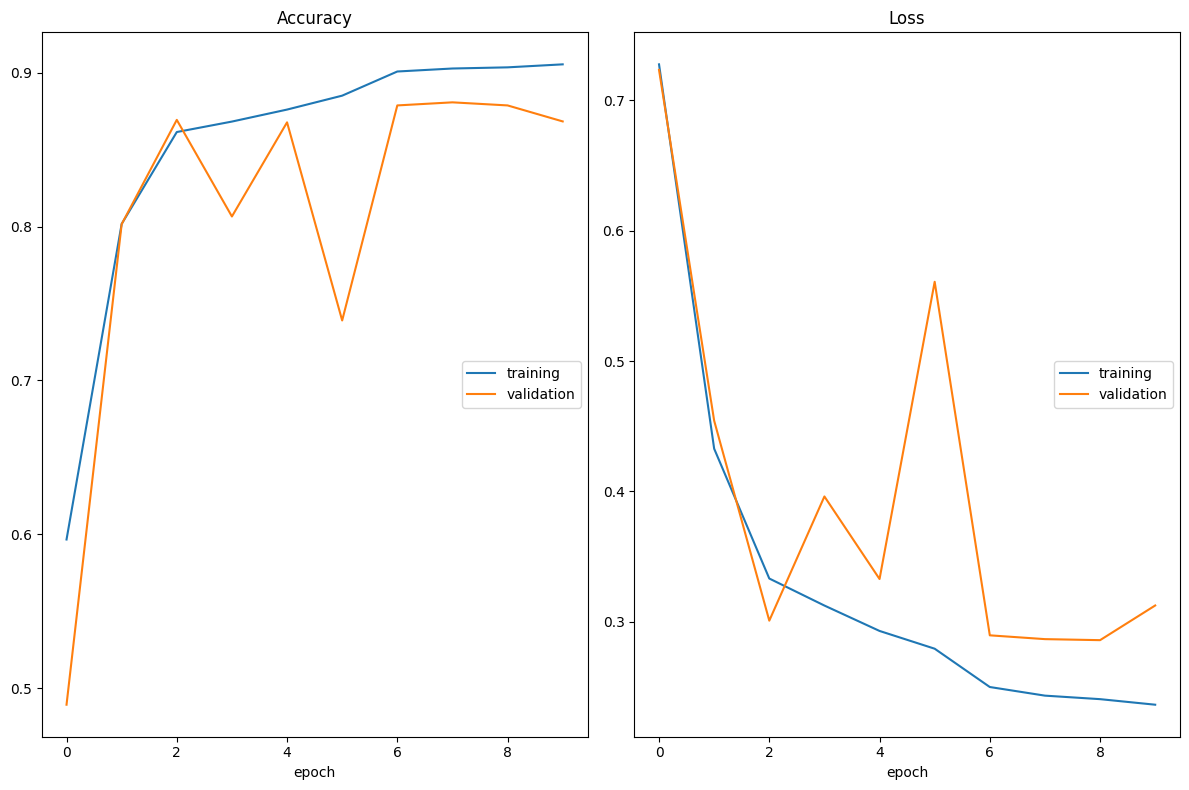

Accuracy
	training         	 (min:    0.597, max:    0.905, cur:    0.905)
	validation       	 (min:    0.489, max:    0.881, cur:    0.868)
Loss
	training         	 (min:    0.236, max:    0.728, cur:    0.236)
	validation       	 (min:    0.286, max:    0.723, cur:    0.313)
625/625 [==============================] - 27s 44ms/step - loss: 0.2364 - acc: 0.9055 - val_loss: 0.3125 - val_acc: 0.8684 - lr: 1.0000e-04


In [ ]:
m = create_model()
BATCH_SIZE = 32 #128, skusim 32 a 64
EPOCHS = 10
callbacks=[
        PlotLossesKeras(),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3),
]

m_h = m.fit(
    xa,
    ya,
    validation_data=(xb, yb),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

In [ ]:
m.evaluate(X_test, y_test)

782/782 [==============================] - 13s 16ms/step - loss: 0.2994 - acc: 0.8732


[0.29939231276512146, 0.8732399940490723]

In [ ]:
def create_conv_model():
  input = Input(shape=(REVIEW_LEN,))
  x = Embedding(DICT_SIZE, 64, input_length=len(X_train[0]))(input)#128
  x = tf.keras.layers.Dropout(0.3)(x)
  x = tf.keras.layers.Conv1D(8, 5, activation="relu", padding="same")(x) #16
  #x = tf.keras.layers.MaxPooling1D()(x)
  x = tf.keras.layers.Flatten()(x)
  output = Dense(1, activation="sigmoid")(x)
  model = Model(input, output)
  model.compile(
      loss="binary_crossentropy",
      metrics=["acc"],
      optimizer=tf.keras.optimizers.Adam()
  )
  return model

def create_lstm_model():
  input = Input(shape=(REVIEW_LEN,))
  x = Embedding(DICT_SIZE, 64, input_length=len(X_train[0]))(input)
  x = tf.keras.layers.Dropout(0.3)(x)
  x = Bidirectional(LSTM(64, return_sequences=False))(x) #128

  output = Dense(1, activation="sigmoid")(x)
  model = Model(input, output)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["acc"],
      loss="binary_crossentropy"
  )
  return model

def create_combined_model():
  input = Input(shape=(REVIEW_LEN,))
  conv = create_conv_model()
  lstm = create_lstm_model()
  conv_output  = conv(input)
  lstm_output =  lstm(input)
  combined = tf.keras.layers.concatenate([conv_output, lstm_output])
  x = tf.keras.layers.BatchNormalization()(combined)

  output = Dense(1, activation="sigmoid")(x)
  model = Model(input, output)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["acc"],
      loss="binary_crossentropy"
  )
  return model

from tensorflow.keras.utils import plot_model
cm = create_combined_model()
plot_model(cm)

Embedding(DICT_SIZE, 64, input_length=len(X_train[0])),
      Bidirectional(LSTM(64, return_sequences=True, dropout=.3, recurrent_dropout=.3)),
      tf.keras.layers.GRU(32),
      Dense(64, activation="relu"),
      tf.keras.layers.Dropout(.5),
      Dense(1, activation="sigmoid")

In [ ]:
def create_chatgpt_model():
  model = tf.keras.models.Sequential([
      Embedding(DICT_SIZE, 16, input_length=len(X_train[0])),
      Bidirectional(LSTM(8, return_sequences=True, dropout=.3, recurrent_dropout=.3)),
      tf.keras.layers.GRU(32),
      #tf.keras.layers.Dropout(.5), #! + som dal na polovicu vsetko
      Dense(32, activation="relu"),
      tf.keras.layers.Dropout(.5),
      Dense(1, activation="sigmoid")
  ])

  model.compile(
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["acc"],
      loss="binary_crossentropy"
  )
  return model

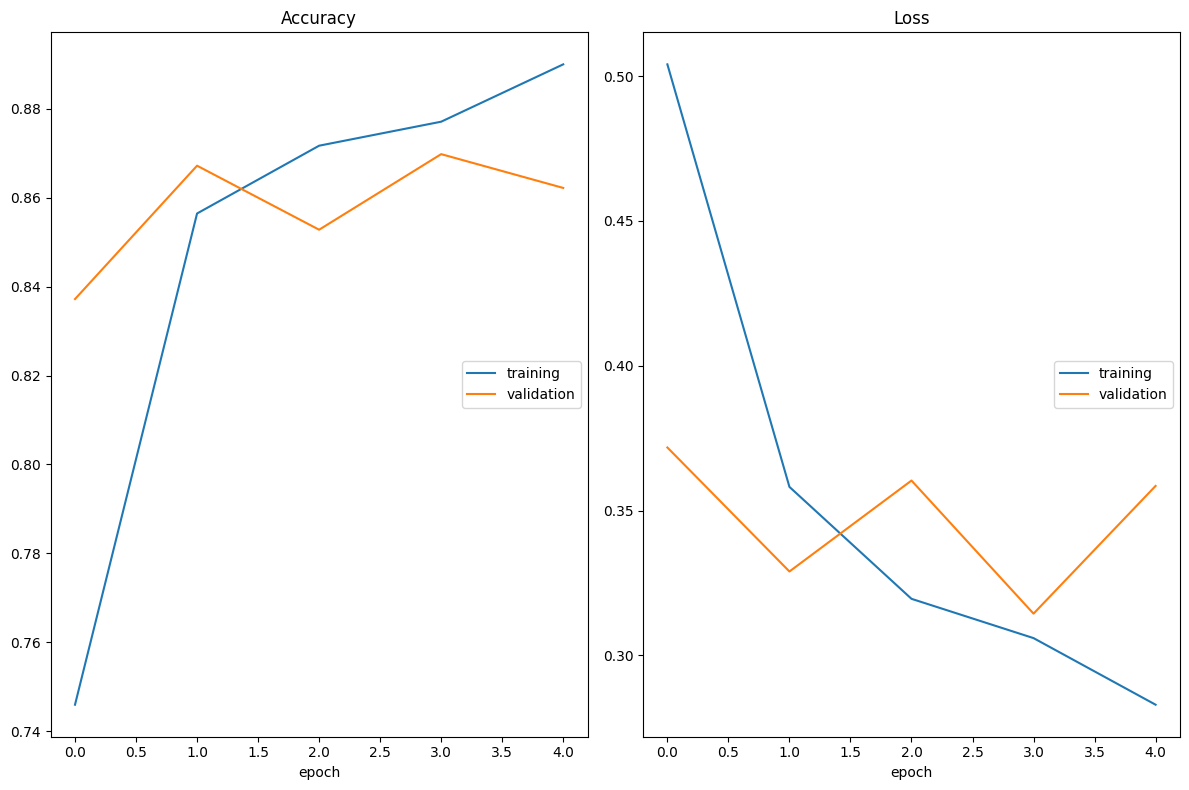

Accuracy
	training         	 (min:    0.746, max:    0.890, cur:    0.890)
	validation       	 (min:    0.837, max:    0.870, cur:    0.862)
Loss
	training         	 (min:    0.283, max:    0.504, cur:    0.283)
	validation       	 (min:    0.314, max:    0.372, cur:    0.358)
625/625 [==============================] - 637s 1s/step - loss: 0.2830 - acc: 0.8900 - val_loss: 0.3585 - val_acc: 0.8622
Epoch 6/10
 79/625 [==>...........................] - ETA: 9:12 - loss: 0.2542 - acc: 0.9051

In [ ]:
c = create_chatgpt_model()
BATCH_SIZE = 32 #128, skusim 32 a 64
EPOCHS = 10
callbacks=[
        PlotLossesKeras(),
        #tf.keras.callbacks.ReduceLROnPlateau(patience=3),
]

c_h = c.fit(
    xa, #[:1000]
    ya, #[:1000]
    validation_data=(xb, yb),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
)

In [ ]:
c.evaluate(X_test, y_test)

782/782 [==============================] - 125s 160ms/step - loss: 1.0169 - acc: 0.7222


[1.0168596506118774, 0.7222399711608887]

In [ ]:
def create_parallel_model():
  input = Input(shape=(256,))
  x = Embedding(DICT_SIZE, 32, input_length=len(X_train[0]))(input) #32;64
  #x = tf.keras.layers.Dropout(0.5)(x)

  x1 = tf.keras.layers.Conv1D(8, 5, activation="relu", padding="same")(x) #16
  x1 = tf.keras.layers.MaxPooling1D()(x1)
  x1 = tf.keras.layers.Dropout(0.5)(x1)
  x1 = tf.keras.layers.Flatten()(x1)

  x2 = Bidirectional(LSTM(32, dropout=0.5, recurrent_dropout=0.5))(x)


  combined = tf.keras.layers.concatenate([x1, x2])

  x = tf.keras.layers.BatchNormalization()(combined)
  x = tf.keras.layers.Dropout(0.5)(x)

  output = Dense(1, activation="sigmoid")(x)

  model = Model(input, output)
  model.compile(
      loss="binary_crossentropy",
      metrics=["acc"],
      optimizer="adam"
  )
  return model

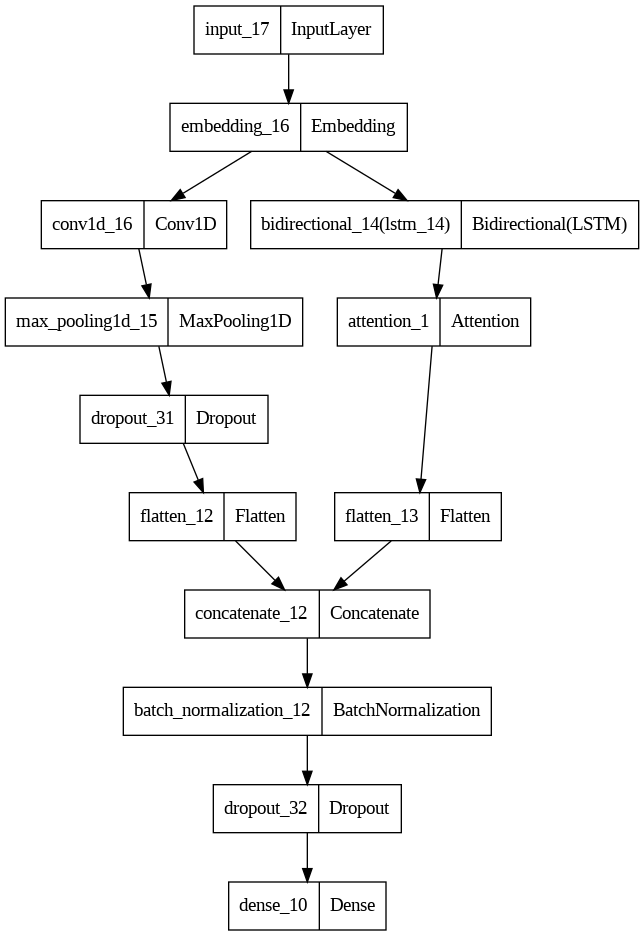

In [ ]:
from tensorflow.keras.utils import plot_model
p_m = create_parallel_model()
plot_model(p_m)

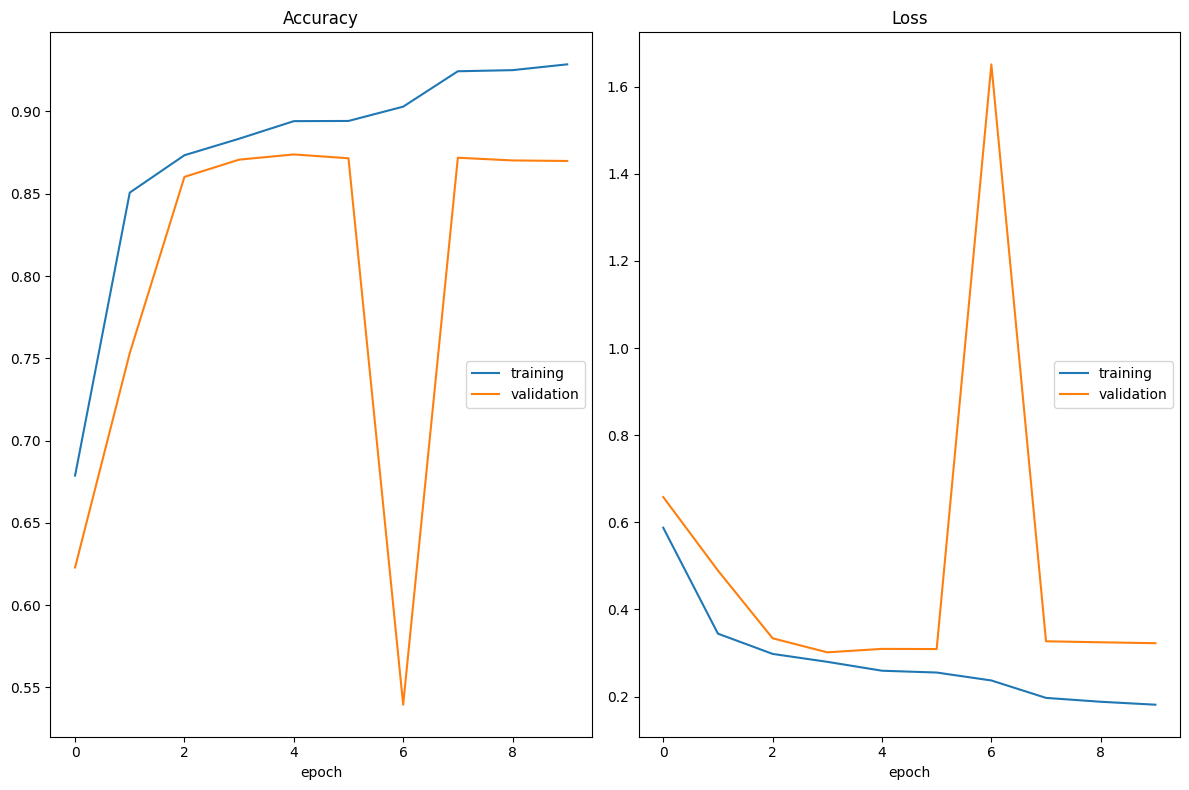

Accuracy
	training         	 (min:    0.679, max:    0.929, cur:    0.929)
	validation       	 (min:    0.539, max:    0.874, cur:    0.870)
Loss
	training         	 (min:    0.181, max:    0.587, cur:    0.181)
	validation       	 (min:    0.301, max:    1.651, cur:    0.322)


In [ ]:
p_m = create_parallel_model()
BATCH_SIZE = 128 #128, skusim 32
EPOCHS = 10
callbacks=[
        PlotLossesKeras(),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3),
]

p_m_h = p_m.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=0
)

In [ ]:
x_a, x_b, y_a, y_b = train_test_split(X_train, y_train, test_size=0.2)

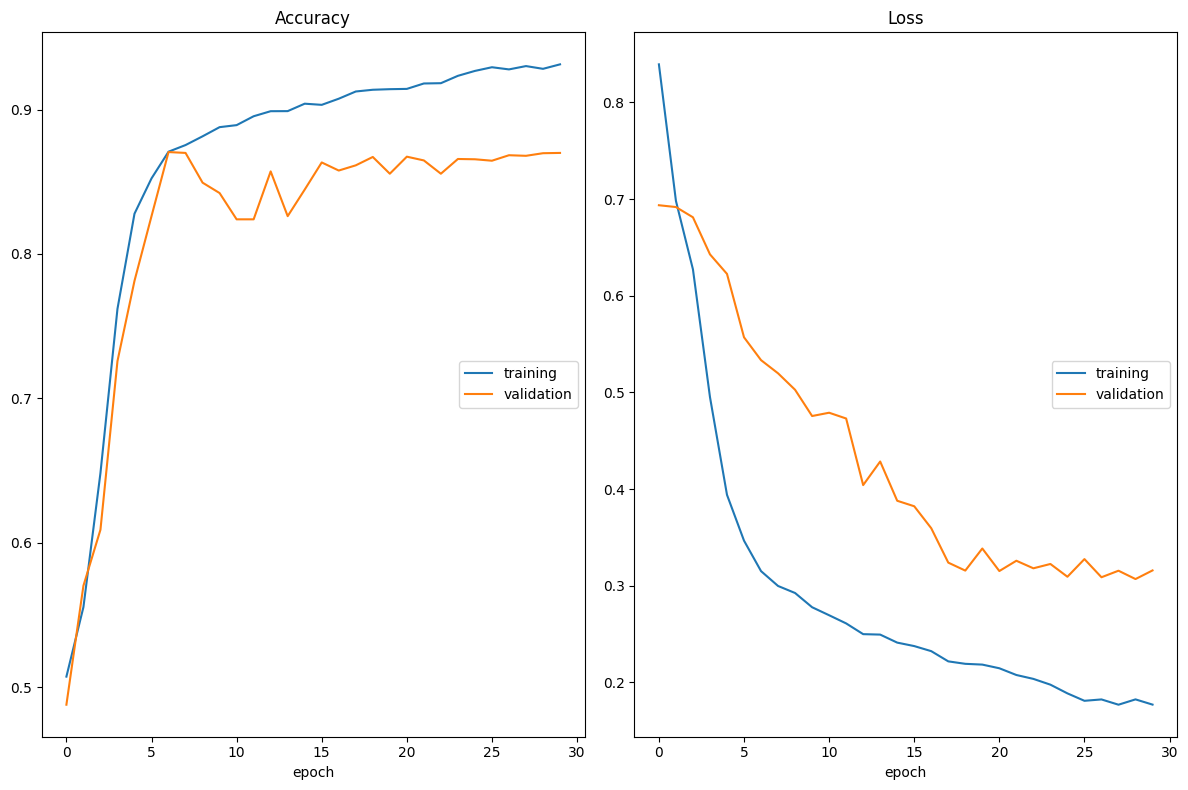

Accuracy
	training         	 (min:    0.507, max:    0.931, cur:    0.931)
	validation       	 (min:    0.488, max:    0.871, cur:    0.870)
Loss
	training         	 (min:    0.177, max:    0.839, cur:    0.177)
	validation       	 (min:    0.307, max:    0.694, cur:    0.316)


In [ ]:
p_m = create_parallel_model()
BATCH_SIZE = 1024 #128, skusim 32
EPOCHS = 30
callbacks=[
        PlotLossesKeras(),
        tf.keras.callbacks.ReduceLROnPlateau(patience=3),
]

p_m_h = p_m.fit(
    x_a,
    y_a,
    validation_data=(x_b, y_b),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=callbacks,
    verbose=0
)